In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('../data/churn-data.csv')
data.head()
cols = data.columns

In [3]:
# Replace ' ' with NaN and convert 'TotalCharges' to float
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Drop rows with NaN in 'TotalCharges'
# data.dropna(subset=['TotalCharges'], inplace=True)

# #replace all the ' ' or NaN with mean of the column if value is numeric
# # Get numeric columns
# numeric_columns = data.select_dtypes(include=[np.number]).columns

# # Replace NaN values with mean for numeric columns
# for col in numeric_columns:
#     data[col].fillna(data[col].mean(), inplace=True)


# Drop the 'customerID' column
data.drop(columns=['customerID'], inplace=True)

In [4]:
df1 = data.copy(deep=True)
categorical_cols = [col for col in data.columns if col not in data.describe().columns]

label_encoders = {}

print('Label Encoder Transformation')
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df1[col] = label_encoders[col].fit_transform(df1[col])
    original_values = label_encoders[col].classes_
    encoded_values = range(len(original_values))
    print(f"{col}:")
    for orig, enc in zip(original_values, encoded_values):
        print(f"    {orig} -> {enc}")
    print()

Label Encoder Transformation
gender:
    Female -> 0
    Male -> 1

Partner:
    No -> 0
    Yes -> 1

Dependents:
    No -> 0
    Yes -> 1

PhoneService:
    No -> 0
    Yes -> 1

MultipleLines:
    No -> 0
    No phone service -> 1
    Yes -> 2

InternetService:
    DSL -> 0
    Fiber optic -> 1
    No -> 2

OnlineSecurity:
    No -> 0
    No internet service -> 1
    Yes -> 2

OnlineBackup:
    No -> 0
    No internet service -> 1
    Yes -> 2

DeviceProtection:
    No -> 0
    No internet service -> 1
    Yes -> 2

TechSupport:
    No -> 0
    No internet service -> 1
    Yes -> 2

StreamingTV:
    No -> 0
    No internet service -> 1
    Yes -> 2

StreamingMovies:
    No -> 0
    No internet service -> 1
    Yes -> 2

Contract:
    Month-to-month -> 0
    One year -> 1
    Two year -> 2

PaperlessBilling:
    No -> 0
    Yes -> 1

PaymentMethod:
    Bank transfer (automatic) -> 0
    Credit card (automatic) -> 1
    Electronic check -> 2
    Mailed check -> 3

Churn:
    No -> 0
 

In [5]:
features = df1.drop('Churn', axis=1)
target = df1['Churn']
cols = features.columns

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)


smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, target)

print("\nClass Distribution:")
print("------------------")
print("Before balancing:")
print(pd.Series(target).value_counts())
print("\nAfter balancing:") 
print(pd.Series(y_balanced).value_counts())


Class Distribution:
------------------
Before balancing:
Churn
0    5174
1    1869
Name: count, dtype: int64

After balancing:
Churn
0    5174
1    5174
Name: count, dtype: int64


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size = 0.20, random_state = 2)

In [7]:
x_train_df = pd.DataFrame(x_train, columns=cols)
y_train_df = pd.DataFrame(y_train, columns=['Churn'])

In [8]:
# Convert training data to DataFrame and add target variable
x_train_test = pd.DataFrame(x_train, columns=cols).assign(Churn=y_train)

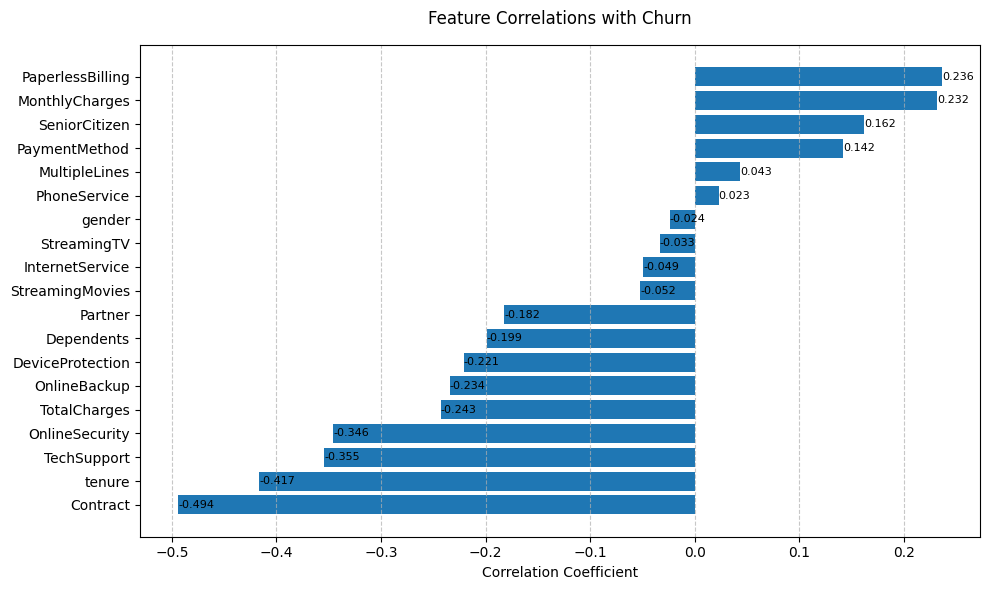

In [9]:
correlations = []
for col in x_train_test.columns:
    if col != 'Churn':
        corr = x_train_test[col].corr(x_train_test['Churn'])
        correlations.append((col, corr))
  
corr_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values('Correlation', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df['Feature'], corr_df['Correlation'])

plt.title('Feature Correlations with Churn', pad=15)
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(corr_df['Correlation']):
    plt.text(v, i, f'{v:.3f}', 
             verticalalignment='center',
             fontsize=8)

plt.tight_layout()
plt.show()

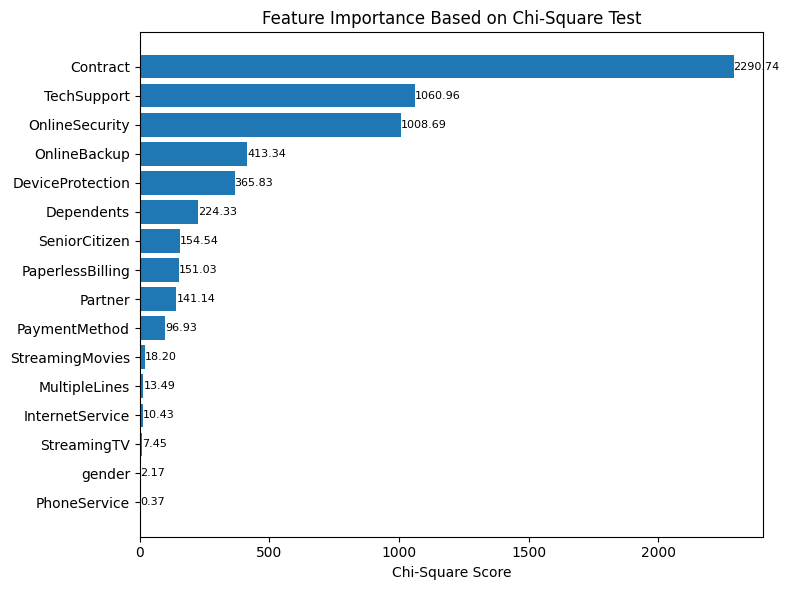

In [10]:
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

features = x_train_df[categorical_features]
target = pd.DataFrame(y_train)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(features, target)

feature_scores = pd.DataFrame({
    'Feature': categorical_features,
    'Chi-Square Score': chi2_selector.scores_
})
feature_scores = feature_scores.sort_values('Chi-Square Score', ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(feature_scores['Feature'], feature_scores['Chi-Square Score'])
plt.xlabel('Chi-Square Score')
plt.title('Feature Importance Based on Chi-Square Test')

for i, v in enumerate(feature_scores['Chi-Square Score']):
    plt.text(v, i, f'{v:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

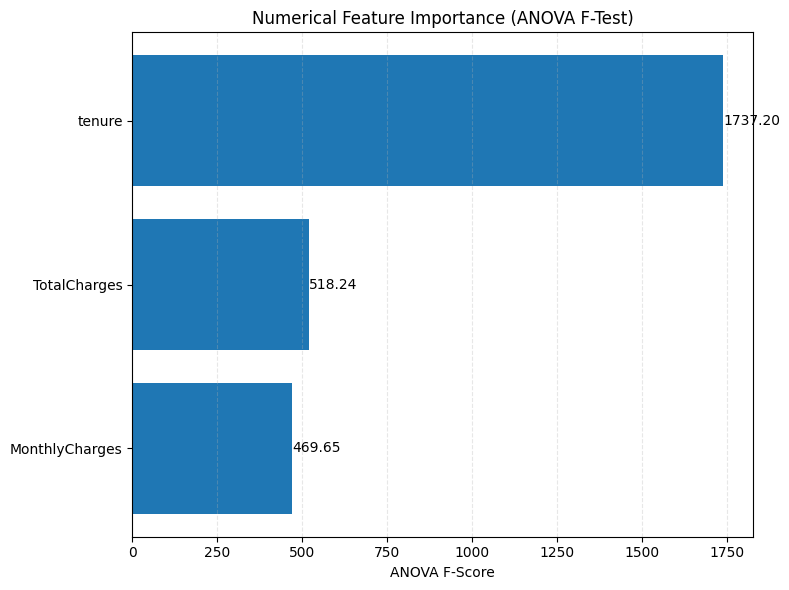

In [11]:
numerical_features = [
    'tenure', 'MonthlyCharges', 'TotalCharges'
]

features = x_train_df[numerical_features]
target = pd.DataFrame(y_train)

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(features, target)

feature_importance = pd.DataFrame({
    'Feature': numerical_features,
    'ANOVA Score': anova_selector.scores_
})
feature_importance = feature_importance.sort_values('ANOVA Score', ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(feature_importance['Feature'], feature_importance['ANOVA Score'])
plt.xlabel('ANOVA F-Score')
plt.title('Numerical Feature Importance (ANOVA F-Test)')

for i, v in enumerate(feature_importance['ANOVA Score']):
    plt.text(v, i, f'{v:.2f}', va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
features_to_drop = ['PhoneService', 'gender', 'StreamingTV', 'StreamingMovies', 
                   'MultipleLines', 'InternetService']

x_train = x_train_df.drop(columns = features_to_drop)

x_test_df = pd.DataFrame(x_test, columns=cols) 
x_test = x_test_df.drop(columns = features_to_drop)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")


Training set shape: (8278, 13)
Test set shape: (2070, 13)


In [13]:

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
x_train_scaled[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])

x_test_scaled[columns_to_scale] = scaler.transform(x_test[columns_to_scale])

# plt.figure(figsize=(12, 6))
# for i, col in enumerate(columns_to_scale):
#     plt.subplot(1, 3, i+1)
#     plt.hist(x_train[col], alpha=0.5, label='Original', bins=30)
#     plt.hist(x_train_scaled[col], alpha=0.5, label='Scaled', bins=30)
#     plt.title(f'{col} Distribution')
#     plt.legend()
# plt.tight_layout()
# plt.show()

x_train = x_train_scaled
x_test = x_test_scaled

In [14]:
def model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    y_pred_proba = classifier.predict_proba(x_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv_scores = cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"CV Score: {cv_scores.mean():.2f} (+/- {cv_scores.std()*2:.2f})")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return accuracy, cv_scores.mean(), cv_scores.std()*2, roc_auc, f1

def model_evaluation(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    classes = ['No Churn', 'Churn']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum():.1%})',
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

### Xgboost

Accuracy: 0.85
CV Score: 0.94 (+/- 0.01)
ROC AUC: 0.94
F1 Score: 0.85
--------------------------------------------------------------------------------


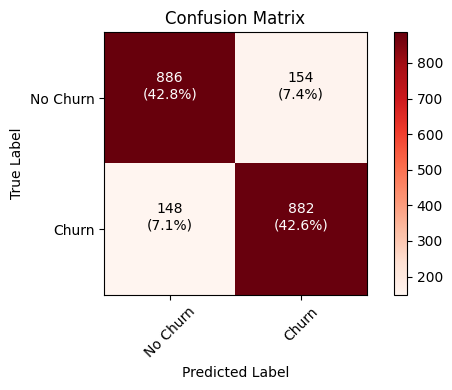


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.85      0.85      1040
       Churn       0.85      0.86      0.85      1030

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070

--------------------------------------------------------------------------------


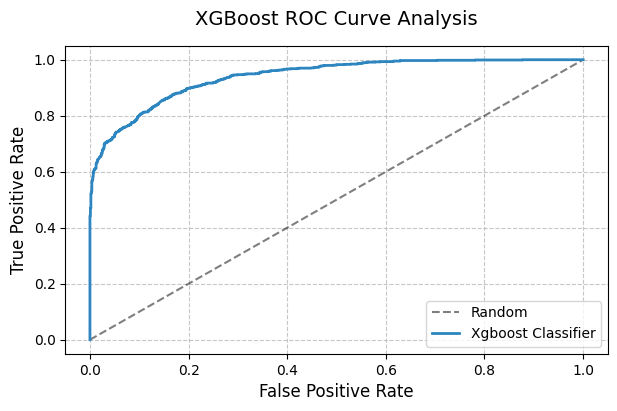

In [15]:

classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
accuracy, cv_mean, cv_std, roc_auc, f1 = model(classifier_xgb, x_train, y_train, x_test, y_test)

print('-'*80)
model_evaluation(classifier_xgb,x_test,y_test)
print('-'*80)

y_pred_prob =classifier_xgb.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 4))

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.plot(fpr, tpr, label='Xgboost Classifier', color='#2E86C1', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('XGBoost ROC Curve Analysis', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()


xgb_results = {
    'Model': 'XGBoost',
    'Accuracy': accuracy,
    'CV Score': cv_mean,
    'CV Std': cv_std,
    'ROC AUC': roc_auc,
    'F1 Score': f1
}


### Random Forest

Accuracy: 0.81
CV Score: 0.90 (+/- 0.02)
ROC AUC: 0.90
F1 Score: 0.81
--------------------------------------------------------------------------------


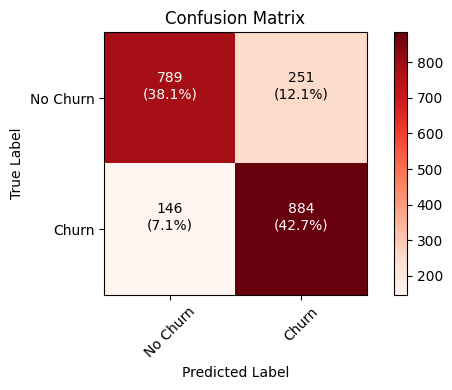


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.76      0.80      1040
       Churn       0.78      0.86      0.82      1030

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070

--------------------------------------------------------------------------------


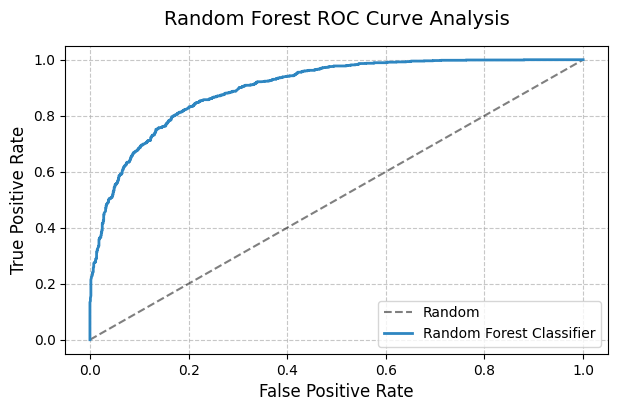

In [16]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)

accuracy, cv_mean, cv_std, roc_auc, f1 = model(classifier_rf, x_train, y_train, x_test, y_test)

print('-'*80)

model_evaluation(classifier_rf,x_test,y_test)

print('-'*80)

y_pred_prob =classifier_rf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 4))

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.plot(fpr, tpr, label='Random Forest Classifier', color='#2E86C1', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest ROC Curve Analysis', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()
rf_results = {
    'Model': 'Random Forest',
    'Accuracy': accuracy,
    'CV Score': cv_mean,
    'CV Std': cv_std,
    'ROC AUC': roc_auc,
    'F1 Score': f1
}


### Decision Tree

Accuracy: 0.80
CV Score: 0.86 (+/- 0.02)
ROC AUC: 0.86
F1 Score: 0.80
--------------------------------------------------------------------------------


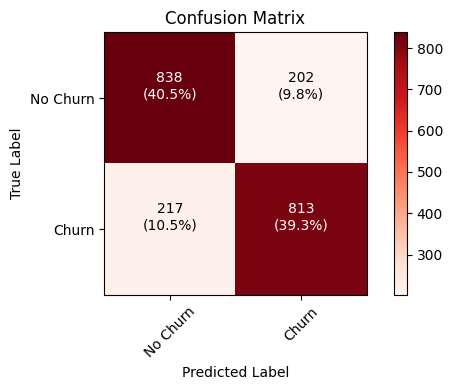


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.79      0.81      0.80      1040
       Churn       0.80      0.79      0.80      1030

    accuracy                           0.80      2070
   macro avg       0.80      0.80      0.80      2070
weighted avg       0.80      0.80      0.80      2070

--------------------------------------------------------------------------------


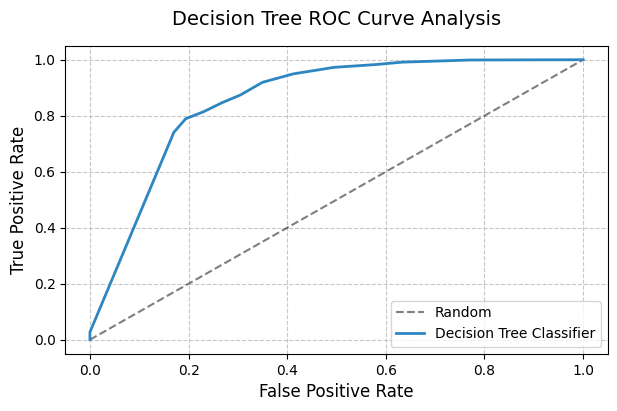

In [17]:

classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)

accuracy, cv_mean, cv_std, roc_auc, f1 = model(classifier_dt, x_train, y_train, x_test, y_test)

dt_results = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy,
    'CV Score': cv_mean,
    'CV Std': cv_std,
    'ROC AUC': roc_auc,
    'F1 Score': f1
}

print('-'*80)

model_evaluation(classifier_dt,x_test,y_test)

print('-'*80)

y_pred_prob =classifier_dt.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 4))

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.plot(fpr, tpr, label='Decision Tree Classifier', color='#2E86C1', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Decision Tree ROC Curve Analysis', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()


### Logistic Regression

Accuracy: 0.77
CV Score: 0.85 (+/- 0.02)
ROC AUC: 0.85
F1 Score: 0.77
--------------------------------------------------------------------------------


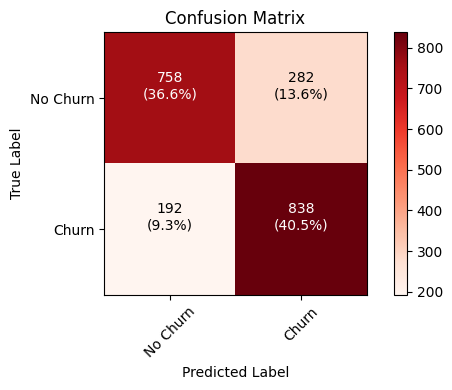


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.80      0.73      0.76      1040
       Churn       0.75      0.81      0.78      1030

    accuracy                           0.77      2070
   macro avg       0.77      0.77      0.77      2070
weighted avg       0.77      0.77      0.77      2070

--------------------------------------------------------------------------------


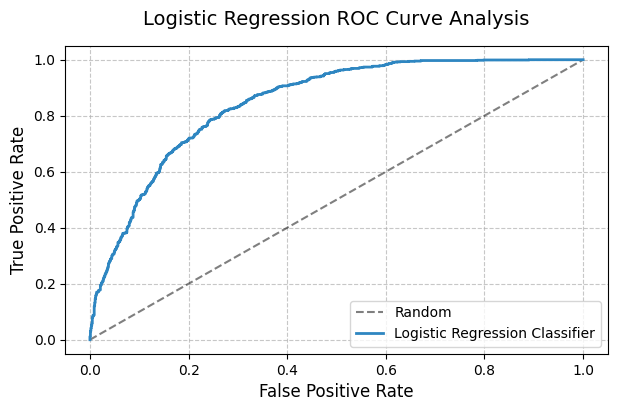

In [18]:


classifier_lr = LogisticRegression()

accuracy, cv_mean, cv_std, roc_auc, f1 = model(classifier_lr, x_train, y_train, x_test, 
                                               y_test)

lr_results = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'CV Score': cv_mean,
    'CV Std': cv_std,
    'ROC AUC': roc_auc,
    'F1 Score': f1
}

print('-'*80)

model_evaluation(classifier_lr,x_test,y_test)

print('-'*80)

y_pred_prob =classifier_lr.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 4))

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.plot(fpr, tpr, label='Logistic Regression Classifier', color='#2E86C1', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Logistic Regression ROC Curve Analysis', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()

In [19]:
inputs = tf.keras.Input(shape=(13,))
x = Dense(128, activation='selu')(inputs)
x = BatchNormalization()(x)
x = Dense(64, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='selu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

loss, accuracy, auc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}") 
print(f"Test AUC: {auc:.4f}")


nn_results = {
    'Model': 'Neural Network',
    'Accuracy': accuracy,
    'CV Score': cv_mean,
    'CV Std': cv_std,
    'ROC AUC': roc_auc,
    'F1 Score': f1
}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7516 - auc: 0.8286 - loss: 0.5067 - val_accuracy: 0.7643 - val_auc: 0.8535 - val_loss: 0.4826 - learning_rate: 0.0010
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.7725 - auc: 0.8546 - loss: 0.4703 - val_accuracy: 0.7614 - val_auc: 0.8644 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7840 - auc: 0.8634 - loss: 0.4569 - val_accuracy: 0.7691 - val_auc: 0.8613 - val_loss: 0.4656 - learning_rate: 0.0010
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7890 - auc: 0.8712 - loss: 0.4476 - val_accuracy: 0.7816 - val_auc: 0.8710 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7874 - auc: 0.8709 - loss: 0.4474 - val_accuracy: 0.7720 - val_auc: 0.8613 - val_loss: 0.4704 - learning_rate: 0.0010
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.

### Results

In [20]:
data = [xgb_results, rf_results, dt_results, lr_results, nn_results]

results_df = pd.DataFrame(data)
results_df.sort_values('Accuracy', ascending=False)


,Model,Accuracy,CV Score,CV Std,ROC AUC,F1 Score
0,XGBoost,0.854106,0.938468,0.012033,0.939380,0.854107
4,Neural Network,0.822222,0.849508,0.021004,0.847584,0.770629
1,Random Forest,0.808213,0.900361,0.016271,0.899247,0.807765
2,Decision Tree,0.797585,0.860059,0.016436,0.855487,0.797567
3,Logistic Regression,0.771014,0.849508,0.021004,0.847584,0.770629
